## Overview
 - Obtain unbiased estimates of a model's performace
 - Diagnose the common problems of machine learning algorithms
 - Fine-tune machine learning models
 - Evaluate predictive models using different performace metrics

## BREAST CANCER data
569 samples of <b>malignant</b> and <b>benign</b> tumor cells. First two columns store unique ID numbers of samples, and corresponding diagnosis (M=malignant, B=binign). Columns 3-32 contain 30 real value features that have been computed from digitized images of the cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant. FROM UCI machine learning repo

In [2]:
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [3]:
## assign 30 features to numpy array X, using LabelEncoder, 
## transform class labels from string to integers
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [4]:
le.transform(['M', "B"])

array([1, 0], dtype=int64)

In [5]:
# split data
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

In [6]:
## Standardize data
## let's assume we want to compress our data from initial 30
## onto lower two-dimensional subspace via PCA
## Instead of going through the fitting and transformation 
## steps for the training and test dataset separately, 
## we can chain the StandardScaler, PCA, and 
## LogisticRegression objects in a pipeline:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                   ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


## Cross-Validation to evaluate model 

#### 'holdout' cross-validation
classic and popular approach, single validation set, that does not change, which we train, tune, evaluate ml model on.

## K-Fold Cross validation
stratified k-fold

In [7]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold

kfold = StratifiedKFold(y=y_train, 
                        n_folds=10,
                        random_state=1)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, 
                np.bincount(y_train[train]), score))
    

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [7]:
print('CV accuracy: %.3f +/- %.3f' % (
                np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


In [8]:
## scikit-learn version
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1) # CPUs to be used, 
## (n_jobs=-1 all available CPUs)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


#### Diagnosing bias and variance problems with learning curves
training and test accuracies as functions of sample size

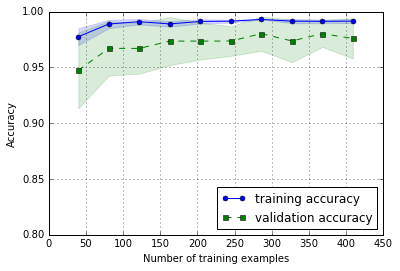

In [16]:
## learning curve from scikit-learn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.learning_curve import learning_curve
pipe_lr = Pipeline([
          ('scl', StandardScaler()),
          ('clf', LogisticRegression(
                       penalty='l2', random_state=0))])
train_sizes, train_scores, test_scores = \
        learning_curve(estimator=pipe_lr,
                      X=X_train,
                      y=y_train,
                      train_sizes=np.linspace(0.1, 1.0, 10),
                      cv=10,
                      n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
         markersize=5, label='training accuracy')
plt.fill_between(train_sizes,
                 train_mean+train_std,
                 train_mean-train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='validation accuracy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

#### Addressing overfitting and underfitting with validation curves
vary the values of the model parameters, i.e. the inverse regularization parameter <b>C</b> in logistic regression

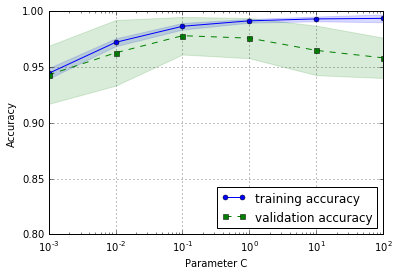

In [18]:
from sklearn.learning_curve import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = \
        validation_curve(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        param_name='clf__C',
                        param_range=param_range,
                        cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, 
         label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show() 
## Validation curve plot for parameter C

## Fine-tuning ML models via Grid Search
hyperparameters -- (tuning parameters) are the parameters in a model that are optimized separately from the training data, for example <b>regularization</b> parameter in logist regression, or the <b>depth</b> parameter of a decision tree

##### Tuning hyperparameters via grid search
Grid search -- brute-force exhuastive search paradigm where we specify a list of values for different hyperparameters and the computer evaluates the model perfomance for each combination to obtain the optimal set:

In [21]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([
        ('scl', StandardScaler()),
        ('clf', SVC(random_state=1))
    ])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
              'clf__kernel': ['linear']},
             {'clf__C': param_range,
             'clf__gamma': param_range,
             'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978022
{'clf__kernel': 'linear', 'clf__C': 0.1}


In [22]:
## use independent test data to estimate performance
## from the best selected model via best_estimator_
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


### Algorithm selection with nested cross-validation

In [24]:
## 5x2 cross-validation, 5 outer loops, 2 inner
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=5,
                 n_jobs=-1)
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.977 +/- 0.004


In [25]:
## tree model for comparison to SVM
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=[{'max_depth': [1,2,3,4,5,6,7, None]}],
    scoring='accuracy',
    cv=5)
scores = cross_val_score(gs,
                        X_train,
                        y_train,
                        scoring='accuracy',
                        cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.908 +/- 0.045


SVM (97.7%) is much better than the decision tree (90.8%), we would expect the SVM to out perform the decision tree on new unclassified data

### Performance Evaluation Metrics
 - precision
 - recall
 - F1-score

In [41]:
## confusion matrix
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


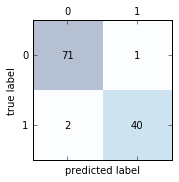

In [42]:
## illustration of matrix above, using plt.matshow
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
               s=confmat[i, j],
               va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [43]:
## precision(PRE), recal(REC), f1-score
from sklearn.metrics import precision_score
from sklearn.metrics  import recall_score, f1_score

print('Precision: %.3f' % precision_score(
        y_true=y_test, y_pred=y_pred))

print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))

print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [44]:
## positive class is labeled as class 1,
## if want to specify different positive label
## can construct our own scorer
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv=10)

#### Plotting ROC

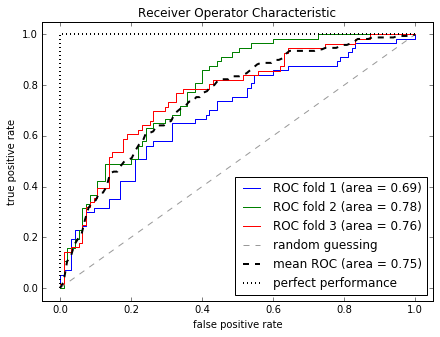

In [45]:
## using only two features for illustration purposes
## make curve more interesting
## also reducing number of folds to 3
from sklearn.metrics import roc_curve, auc
from scipy import interp

X_train2 = X_train[:, [4,14]]
cv = StratifiedKFold(y_train, n_folds=3, random_state=1)
fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],                          
                         y_train[train]).predict_proba(X_train2[test])    
    fpr, tpr, thresholds = roc_curve(y_train[test], 
                                    probas[:, 1], 
                                    pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, 
             tpr, 
             lw=1, 
             label='ROC fold %d (area = %0.2f)' 
                    % (i+1, roc_auc))
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         color=(0.6, 0.6, 0.6), 
         label='random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], 
         [0, 1, 1], 
         lw=2, 
         linestyle=':', 
         color='black', 
         label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

In [46]:
## if just want ROC AUC
pipe_svc = pipe_svc.fit(X_train2, y_train)
y_pred2 = pipe_svc.predict(X_test[:, [4,14]])

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print('ROC AUC: %.3f' % roc_auc_score(
        y_true=y_test, y_score=y_pred2))

print('Accuracy: %.3f' % accuracy_score(
       y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.671
Accuracy: 0.728


In [48]:
## SCORING METRICS FOR MULTICLASS CLASSIFICATION
## while macro-average is the default for multiclass
## can speficy method via average param:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')

# Summary
In the beginning of this chapter, we discussed how to chain different transformation techniques and classifiers in convenient model pipelines that helped us to train and evaluate machine learning models more efficiently. We then used those pipelines to perform k-fold cross-validation, one of the essential techniques for model selection and evaluation. Using k-fold cross-validation, we plotted learning and validation curves to diagnose the common problems of learning algorithms, such as overfitting and underfitting. Using grid search, we further fine-tuned our model. We concluded this chapter by looking at a confusion matrix and various different performance metrics that can be useful to further optimize a model's performance for a specific problem task. Now, we should be well-equipped with the essential techniques to build supervised machine learning models for classification successfully.